For this project, the goal was to get some measures of burst quality from productions of word initial /d/ in the production of both Spanish and English lexical items by native speakers of Mexican Spanish.  The data consists of a single audio file for each subject, with two accompanying forced aligned TextGrids -- one for each language's words.  All target items are spoken in isolation.

In [1]:
import os.path  # For some basic file functionality
import re  # For regular expessions

import audiolabel  # To work with TextGrids
import parselmouth  # To incorporate Praat features in this notebook

import pandas as pd  # For managing dataframes
import matplotlib.pyplot as plt  # For plotting data

So let's have a look at the data!  We've got some sound files we can read as a `parselmouth` Sound object.

In [2]:
psnd = parselmouth.Sound('./S03/S03_words.wav')
print(psnd)

Object type: Sound
Object name: <no name>
Date: Thu Feb 21 13:04:53 2019

Number of channels: 1 (mono)
Time domain:
   Start time: 0 seconds
   End time: 689.9112925170068 seconds
   Total duration: 689.9112925170068 seconds
Time sampling:
   Number of samples: 30425088
   Sampling period: 2.2675736961451248e-05 seconds
   Sampling frequency: 44100 Hz
   First sample centred at: 1.1337868480725624e-05 seconds
Amplitude:
   Minimum: -0.0285949707 Pascal
   Maximum: 0.0827941895 Pascal
   Mean: 9.94665048e-06 Pascal
   Root-mean-square: 0.000767057389 Pascal
Total energy: 0.000405927962 Pascal² sec (energy in air: 1.01481991e-06 Joule/m²)
Mean power (intensity) in air: 1.47094259e-09 Watt/m² = 31.68 dB
Standard deviation in channel 1: 0.000766992908 Pascal



There are many ways to interact with Sound objects, but in their most basic form, digital audio is a series of numbers, and we can easily access the audio data in this format, and manipulate like we might with any numerical array.

In [3]:
psnd.as_array()

array([[8.27941895e-02, 8.26110840e-02, 8.26416016e-02, ...,
        2.13623047e-04, 0.00000000e+00, 3.05175781e-05]])

In [4]:
2*psnd.as_array()

array([[1.65588379e-01, 1.65222168e-01, 1.65283203e-01, ...,
        4.27246094e-04, 0.00000000e+00, 6.10351562e-05]])

In [5]:
max(psnd.as_array()[0])-min(psnd.as_array()[0])

0.11138916015625

We can *also* interact with this object in mostly the same way that we'd interact with a Sound object in Praat.  

In [6]:
# some properties
print(psnd.class_name)
print(psnd.duration)
print(psnd.n_samples)

# some methods
print(psnd.get_power())
print(psnd.extract_part(19.75,20.25).get_index_from_time(.25))

Sound
689.9112925170068
30425088
5.883770375953192e-07
11025.49999999993


And fortunately for us, these two ways of interacting with the object play well with each other (for the most part).

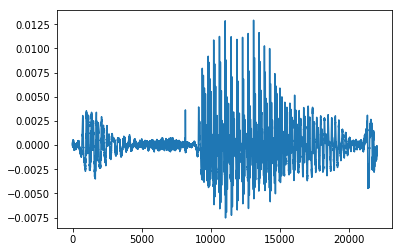

In [7]:
plt.plot(psnd.extract_part(19.75,20.25).as_array()[0])

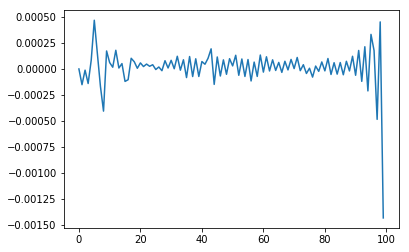

In [8]:
plt.plot(psnd.extract_part(19.75,20.25).resample(200).as_array()[0])

So let's see how we can gather the following information from the audio:
- Frequency distrbution information
 - Center of Gravity
 - Standard Deviation
 - Skewness
 - Kurtosis
- Intensity

In [ ]:
snippet = psnd.extract_part(19.75,20.25)
snippet.get_intensity()

In [ ]:
snip_spectrum = snippet.to_spectrum()
print(snip_spectrum.get_center_of_gravity())
print(snip_spectrum.get_standard_deviation())
print(snip_spectrum.get_skewness())
print(snip_spectrum.get_kurtosis())

You can access the same functionality of all Praat functions in Parselmouth using the call function.  The syntax you'll use is borrowed directly from Praat, but it is helpful when you need a function that hasn't yet been implemented in Parselmouth.  We don't need to in this case, but let's see how it works anyway.

In [ ]:
from parselmouth.praat import call as pcall

In [ ]:
pcall(snip_spectrum, "Get centre of gravity") # what's the mistake here?

In [ ]:
pcall(snip_spectrum, "Get center of gravity", 2.0) # what's the mistake here?

In [ ]:
# does this give us the same result as the Parselmouth method?
snip_spectrum.get_center_of_gravity() == pcall(snip_spectrum, "Get centre of gravity", 2.0)

Now, we can do routenize this by writing some functions and using some fun pandas tricks!  In particular, the following uses the `as_df` function of audiolabel to turn a labelmanager item into a dataframe, and then `apply` from pandas to apply functions to rows of data.

In [ ]:
tg = audiolabel.LabelManager(from_file='./S03/S03_words_Spanish_aligned.TextGrid', from_type='praat')
words = tg.tier('word').as_df()
words.head(10)

In [ ]:
words['isaword'] = words['text'].apply(lambda x: x not in ['{SIL}', ''])
words.head(10)

In [ ]:
def duration(token):
    return token['t2']-token['t1']

words['duration2'] = words.apply(duration, axis=1)
words.head(10)

### get_freq_dist

This is a function that takes a sound object and a row from a datafarme that contains details from a token.  This row may contain any kind of information, but it must minimally include an ending time (T2).

As written, the function calculates the center of gravity, standard deviation, skewness, and kurtosis of the frequency distribution of the sound *during a window of 50ms, right-aligned to the ending time*, and returns a tuple (an unordered list) containing these values.  You can change this to any number of other windows, as we discussed.  I've included a commented out line showing how you change it so that it analyzes the whole window from the beginning of the token to the end of the token.

In [ ]:
# arguments
#   TOKEN: a row of data from a dataframe containing, minimally, a starting (t1) and ending time (t2)
#   PSND: a Parselmouth Sound object
# returns
#   a tuple containing the center of gravity, SD, skewness, and kurtosis of the frequency distribution of PSND starting from 50ms
#     token.t2 and ending at token.t2
def get_freq_dist(token, psnd):

    # cut out a part of PSND and turn it into a Spectrum object
    s = psnd.extract_part(token['t2']-0.05, token['t2']).to_spectrum()  # 50ms window
    
    # generate values and return
    return [s.get_center_of_gravity(), s.get_standard_deviation(), s.get_skewness(), s.get_kurtosis()]

### get_intensity_values

This function is similar to `get_freq_dist`, except that it gets intensity values, and it returns values the same 50ms window as `get_freq_dist` and the 50ms window *following* the end of the token.

In [ ]:
# arguments
#   TOKEN: a row of data from a dataframe containing, minimally, a starting (t1) and ending time (t2)
#   PSND: a Parselmouth Sound object
# returns
#   a tuple containing the intensity of the burst (from 50ms before end of token) and the following vowel (until 50ms 
#     after the end of token)
def get_intensity_values(token, psnd):

    # cut out a part of PSND and find its intensity
    db_d = psnd.extract_part(token['t2']-0.05, token['t2']).get_intensity()  # 50ms window
    db_v = psnd.extract_part(token['t2'], token['t2']+0.05).get_intensity()  # do the same for the following 50ms
    
    # return values
    return [db_d, db_v]

### make_burst_df

This is a function that takes a sound object and TextGrid, and generates a dataframe containing word and burst information for each valid stimulus item in the TextGrid's `words` tier. 
The TextGrid should contain at least two tiers, named `words` and `phones`.  Other tiers may exist, and will be ignored.

As written, the function turns the TextGrid into a dataframe containing only the /d/s that are word onsets, then applies the frequency distribution function `get_freq_dist` to each.

In [ ]:
# arguments
#   PSND: a Parselmouth Sound object
#   TG: a TextGrid object containing the tiers 'words' and 'phones'
# returns
#   a dataframe version of the TextGrid's 'words' tier with additional measurements: center of gravity, SD, skewness, 
#     and kurtosis of the frequency distribution of PSND starting from 50ms
def make_burst_df(psnd, tg):

    # turn the TG into a data frame.  as_df returns a dataframes for each tier, so we'll take the first one, the phone tier 
    df = tg.as_df()[0]

    df['word'] = df.center.apply(lambda x: tg.labels_at(x).word.text)  # populate the word tier
    df['word_onset'] = df.t1.apply(lambda x: tg.labels_at(x).word.t1 == x)  # determine if row's phone is the onset of the word
    df = df[((df.text=='D') | (df.text=='d')) & (df.word_onset)]  # restrict the dataframe to onset /d/s

    df['burstvalues'] = df.apply(get_freq_dist, args=([psnd]), axis=1)  # get and store the burst COG, SD, etc
    # save each burst value in its own column
    df['cog'] = df.burstvalues.apply(lambda x: x[0])
    df['sd'] = df.burstvalues.apply(lambda x: x[1])
    df['skew'] = df.burstvalues.apply(lambda x: x[2])
    df['kurtosis'] = df.burstvalues.apply(lambda x: x[3])
    
    df['dbvalues'] = df.apply(get_intensity_values, args=([psnd]), axis=1)  # get and store the intensity values
    df['db_d'] = df.dbvalues.apply(lambda x: x[0])
    df['db_v'] = df.dbvalues.apply(lambda x: x[1])
    
    return df[['word','t1','t2','cog','sd','skew','kurtosis','db_d','db_v']]  # return the dataframe, but only these columns

This script assumes that the following data structure, where each subject has their own folder containing their recording and both English and Spanish aligned TextGrids:
```
./
./S01
./S01/S01_words.wav
./S01/S01_English_aligned.TextGrid
./S01/S01_Spanish_aligned.TextGrid
./S02
./S02/S02_words.wav
./S02/S02_English_aligned.TextGrid
./S02/S02_Spanish_aligned.TextGrid
./etc...
```
You can include other files in each subject's folder as you wish, and the script will just ignore them.

In [ ]:
datadir = '.'  # Where's the data?  For now, set to current working directory, but can be changed.
subjects = [f for f in os.listdir(datadir) if re.match('S\d\d',f)]  # get the list of subjects, using regex to match
subjects  # check the list of subjects

Now that we know what subjects there are, we should be able to predict the names of the audio and annotation files.

In [ ]:
audiosuffix = '_words.wav'
engtgsuffix = '_words_English_aligned.TextGrid'
spatgsuffix = '_words_Spanish_aligned.TextGrid'

Ok!  Now we're ready to process the data!  We'll iterate through each subject, and send each pair of audio+textgrid to `make_burst_df` for processing, then combine the resulting data into a master single dataframe for further analysis.

In [ ]:
# set up the master dataframe
df = pd.DataFrame(columns=['speaker','language','word','t1','t2','cog','sd','skew','kurtosis','db_d','db_v'])

for s in subjects:  # iterate through the subjects
    
    # set up paths to the audio files and annotation textgrids
    wav_file = os.path.join(datadir,s,s+audiosuffix)
    tg_eng_file = os.path.join(datadir,s,s+engtgsuffix)
    tg_spa_file = os.path.join(datadir,s,s+spatgsuffix)

    # read the audiofile as a Parselmouth Sound object, and the annotations as labelmanagers
    psnd = parselmouth.Sound(wav_file)
    tg_eng = audiolabel.LabelManager(from_file=tg_eng_file,from_type='praat')
    tg_spa = audiolabel.LabelManager(from_file=tg_spa_file,from_type='praat')

    edf = make_burst_df(psnd, tg_eng)  # make a dataframe from the English words
    edf['language'] = 'English'  # add a language column and set it to 'English'
    edf['speaker'] = s  # add a column for speaker number
    sdf = make_burst_df(psnd, tg_spa)  # do the same thing for Spanish
    sdf['language'] = 'Spanish'
    sdf['speaker'] = s
    
    # join the two dataframes with the master dataframe, and add speaker as a column
    df = df.append(edf, sort=False)
    df = df.append(sdf, sort=False)

Let's have a sneak peek at the data!

In [ ]:
df.head()

We can use the intensity columns to calculate two different versions of relative intensity.  By saving both columns, we can compare them and make a choice later.

In [ ]:
df['db_ratio']=df.db_d/df.db_v  # greater than 1 means the burst is louder than the vowel, and higher values are louder bursts
df['db_diff']=df.db_d-df.db_v  # positive means the burst is louder than the vowel, and higher values are louder bursts

Now let's make some plots...  *This cell requires an seaborn, which is not installed by default in the BPM!*

In [ ]:
import seaborn as sns

f, axes = plt.subplots(2, 3, figsize=(20, 10))  # set up an empty plot with 2x3 subplots
sns.boxplot(data=df, x='speaker', y='cog', hue='language', ax=axes[0,0])
sns.boxplot(data=df, x='speaker', y='sd', hue='language', ax=axes[0,1])
sns.boxplot(data=df, x='speaker', y='skew', hue='language', ax=axes[0,2])
sns.boxplot(data=df, x='speaker', y='kurtosis', hue='language', ax=axes[1,0])
sns.boxplot(data=df, x='speaker', y='db_diff', hue='language', ax=axes[1,1])
sns.boxplot(data=df, x='speaker', y='db_ratio', hue='language', ax=axes[1,2])